In [1]:
from nilearn import plotting, datasets
from nilearn import surface
from utils import RESULTS_DIR
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Circle
from matplotlib.colors import ListedColormap

import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img
from nilearn.datasets import fetch_atlas_destrieux_2009

import os
import numpy as np
import seaborn as sns

from utils import TWO_STAGE_GLM_DATA_DIR, ROOT_DIR
from analyses.ridge_regression_decoding import get_functional_mask, get_anatomical_mask, REGIONS_HIGH_LEVEL_VISUAL, REGIONS_LANGUAGE, REGIONS_LOW_LEVEL_VISUAL, MASK_FUNCTIONAL_LANGUAGE, MASK_FUNCTIONAL_VISUAL1, MASK_FUNCTIONAL_VISUAL2, MASK_ANATOMICAL_LANGUAGE

sns.set(font_scale=1.0)
MASK_PALETTE = sns.color_palette('Set2')[3:3+4][::-1][1:]

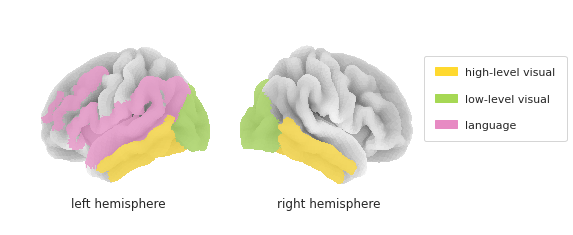

In [2]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
labels = destrieux_atlas['labels']
fsaverage = datasets.fetch_surf_fsaverage()

fig, axes = plt.subplots(1, 2, figsize=(6, 4), subplot_kw={'projection': '3d'})

for axis, hem_short, hem in zip(axes, ['L', 'R'], ['left', 'right']):
    parcellation = destrieux_atlas[f'map_{hem}']

    regions_compatible_lang = [str.encode(r[2:]) for r in REGIONS_LANGUAGE if r.startswith(hem_short)]
    pcc_regions_indices_lang = [labels.index(r) for r in regions_compatible_lang]
    pcc_labels_lang = [np.where(parcellation == index)[0] for index in pcc_regions_indices_lang]
    pcc_labels_lang = np.concatenate(pcc_labels_lang) if len(pcc_labels_lang) > 0 else []
    
    regions_compatible_vision_low = [str.encode(r[2:]) for r in REGIONS_LOW_LEVEL_VISUAL if r.startswith(hem_short)]
    pcc_regions_indices_vision_low = [labels.index(r) for r in regions_compatible_vision_low]
    pcc_labels_vision_low = np.concatenate([np.where(parcellation == index)[0] for index in pcc_regions_indices_vision_low])
    
    regions_compatible_vision_high = [str.encode(r[2:]) for r in REGIONS_HIGH_LEVEL_VISUAL if r.startswith(hem_short)]
    pcc_regions_indices_vision_high = [labels.index(r) for r in regions_compatible_vision_high]
    pcc_labels_vision_high = np.concatenate([np.where(parcellation == index)[0] for index in pcc_regions_indices_vision_high])
    
    # Transform ROI indices in ROI map
    roi_map = np.zeros(parcellation.shape[0], dtype=int)
    roi_map[pcc_labels_vision_high] = 1
    roi_map[pcc_labels_vision_low] = 2
    roi_map[pcc_labels_lang] = 3

    cmap = ListedColormap(MASK_PALETTE) if hem == 'left' else ListedColormap(MASK_PALETTE[:2])
    plotting.plot_surf_roi(
        fsaverage[f'pial_{hem}'],
        roi_map=roi_map,
        hemi=hem,
        view='lateral', #anterior #[270.0, 90.0]
        bg_map=fsaverage[f'sulc_{hem}'],
        bg_on_data=True,
        cmap=cmap,
        title=f'{hem}',
        axes=axis,
        # alpha=0.5,
    )
    
names = ["high-level visual", "low-level visual", "language"]
# legend_elements = [Line2D([0], [0], marker='o', color='g', label=label, markerfacecolor=color, markersize=20) for color, label in zip(MASK_PALETTE, names)]
legend_elements = [Circle((0, 0), radius=5, color=color, label=label) for color, label in zip(MASK_PALETTE, names)]
axes[0].set_title('left hemisphere', pad=0, y=0.1)
axes[-1].set_title('right hemisphere', pad=0, y=0.1)
axes[0].set_facecolor('w')
axes[-1].set_facecolor('w')

lgd = axes[-1].legend(handles=legend_elements, labelspacing = 1.5, borderpad=1, bbox_to_anchor=(1.6, 0.8), facecolor='w')
plt.subplots_adjust(hspace=0, wspace=-0.05, bottom=0, left=0, right=1)
# plt.tight_layout(pad=-100)
# fig.set_size_inches(18.5, 8, forward=True)
plt.savefig(os.path.join(RESULTS_DIR, f"roi_masks.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')